In [328]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [329]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [330]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [331]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [332]:
tf.keras.backend.clear_session()

In [333]:
subject = 'Paraíba - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [334]:
data = pd.read_csv('2003_mo_model_input_PB.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Paraíba - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,38.426,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,31.672,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,28.775,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,28.571,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,31.613,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


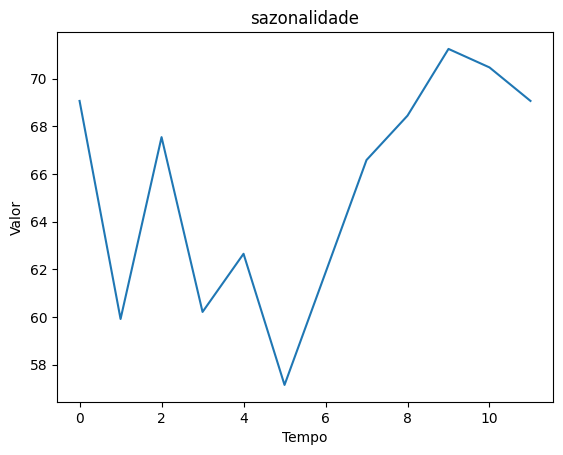

,sazonalidade
sazonalidade,
0,69.069500
1,59.915333
2,67.549780
3,60.211663
4,62.652825
5,57.147556
6,61.864141
7,66.588847
8,68.451435


In [335]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [336]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraíba - Consumo de Cimento (t)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,69.069500,38.426
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,59.915333,31.672
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,67.549780,28.775
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,60.211663,28.571
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,62.652825,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.652825,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.147556,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.864141,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.588847,NaN


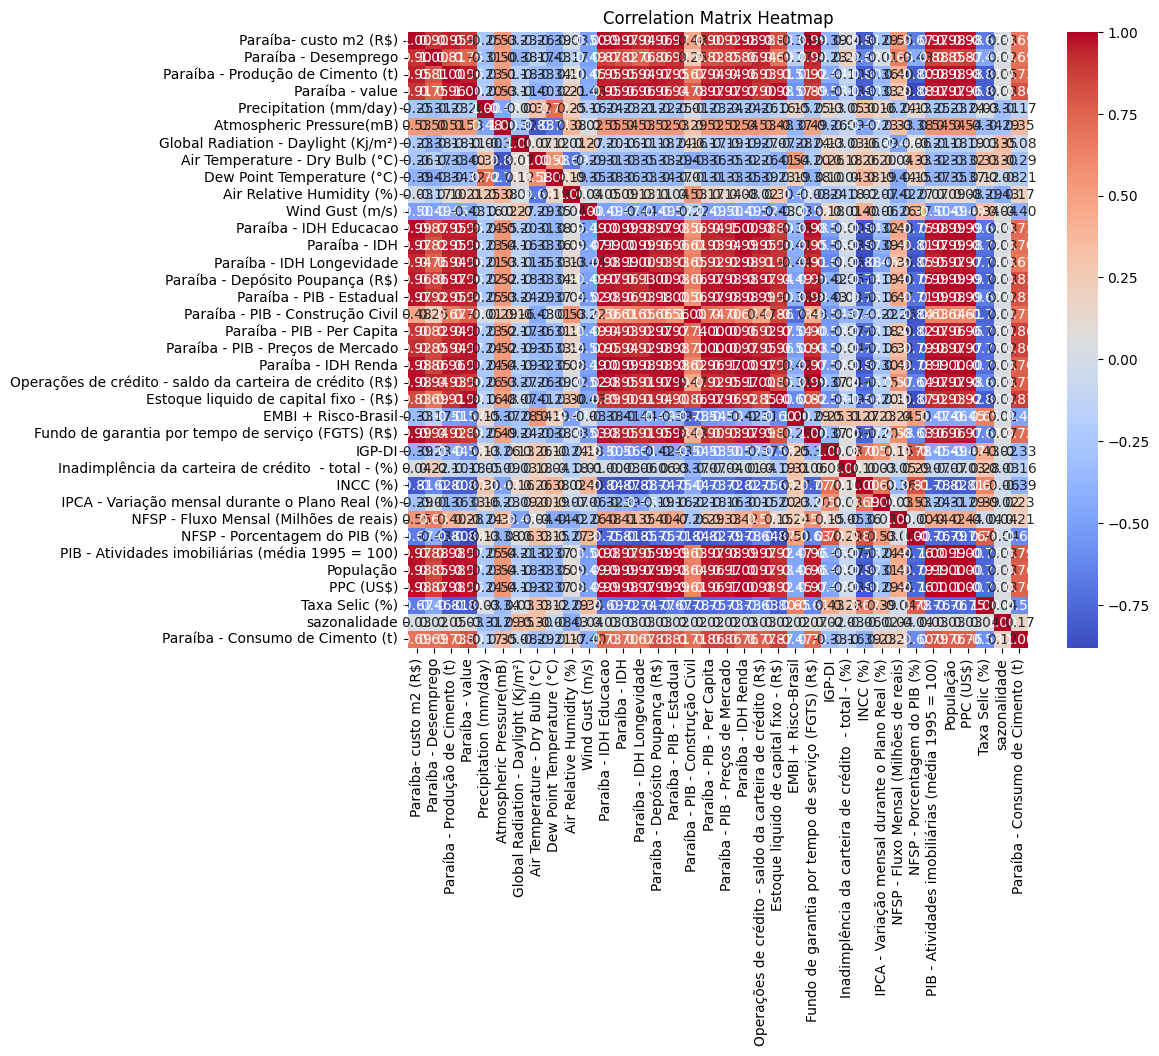

In [337]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [338]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 'Air Relative Humidity (%)',
                 'Paraíba - IDH Longevidade',
                 'Paraíba - IDH Renda',
                 'Paraíba - Depósito Poupança (R$)',
                 'Paraíba - PIB - Estadual', 
                 'Inadimplência da carteira de crédito  - total - (%)',
                 'Paraíba - PIB - Per Capita',
                 'Paraíba - PIB - Preços de Mercado'], axis=1)
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraíba - Consumo de Cimento (t)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,22.497513,19.371613,4.942143,0.592931,0.656510,1.631334e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,69.069500,38.426
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,22.497092,19.371751,4.939870,0.593396,0.656949,1.632950e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,59.915333,31.672
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,22.496846,19.371831,4.938543,0.593862,0.657388,1.634566e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,67.549780,28.775
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,22.496820,19.371840,4.938401,0.594327,0.657827,1.636182e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,60.211663,28.571
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,22.616890,19.394367,4.915516,0.594792,0.658266,1.637798e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,62.652825,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.652825,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.147556,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.864141,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.588847,NaN


In [339]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.552926,-0.800943,-2.092830,-2.424081,0.010092,-0.251051,-0.130628,0.076478,1.422757,-1.900784,-2.168844,-2.484291,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.818230
1,-1.532830,-0.805366,-2.140285,-2.392248,0.010389,-0.249966,-0.131105,0.076697,1.417180,-1.876333,-2.133132,-2.436666,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.197762
2,-1.513964,-0.809789,-2.109587,-2.359718,0.010563,-0.249333,-0.131383,0.076825,1.413928,-1.851882,-2.097421,-2.389041,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.483547
3,-1.496644,-0.814212,-2.074479,-2.326517,0.010581,-0.249265,-0.131413,0.076839,1.413579,-1.827431,-2.061709,-2.341417,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.132502
4,-1.479967,-0.818635,-1.990458,-2.292670,0.116637,-0.352729,0.004435,0.112697,1.357455,-1.802980,-2.025998,-2.293792,-1.359394,-2.241431,0.494336,-1.388786,2.955412,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.594893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.714417,1.272641,1.885384,0.924040,-1.873518,1.126091,-0.476338,-1.806568,0.126603,1.308965,1.235988,-0.170948,1.316363,0.389193,-0.244459,1.237409,0.589021,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,0.271924
188,1.737129,1.277530,1.959697,0.934231,-1.840689,0.657168,-0.026902,-1.614287,0.068512,1.307454,1.228601,-0.163231,1.330590,0.370392,-0.199028,1.214214,1.043728,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.682116
189,1.761419,1.282419,2.094602,0.957607,-1.364317,0.418383,0.487147,-1.299644,-0.033523,1.305943,1.221214,-0.155514,1.352241,0.351592,-0.173807,1.409043,1.387010,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.299061
190,1.787367,1.287308,2.203705,0.987746,-0.105041,0.157363,0.777098,-0.647516,-0.449403,1.304432,1.213827,-0.147797,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,1.127973


In [340]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      31.891
1      26.089
2      32.066
3      26.351
4      27.348
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Paraíba - Consumo de Cimento (t), Length: 249, dtype: float64

In [341]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.552926,-0.800943,-2.092830,-2.424081,0.010092,-0.251051,-0.130628,0.076478,1.422757,-1.900784,-2.168844,-2.484291,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.818230
1,-1.532830,-0.805366,-2.140285,-2.392248,0.010389,-0.249966,-0.131105,0.076697,1.417180,-1.876333,-2.133132,-2.436666,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.197762
2,-1.513964,-0.809789,-2.109587,-2.359718,0.010563,-0.249333,-0.131383,0.076825,1.413928,-1.851882,-2.097421,-2.389041,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,0.483547
3,-1.496644,-0.814212,-2.074479,-2.326517,0.010581,-0.249265,-0.131413,0.076839,1.413579,-1.827431,-2.061709,-2.341417,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.132502
4,-1.479967,-0.818635,-1.990458,-2.292670,0.116637,-0.352729,0.004435,0.112697,1.357455,-1.802980,-2.025998,-2.293792,-1.359394,-2.241431,0.494336,-1.388786,2.955412,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.594893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.132127,1.300589,0.747301,0.928050,0.467517,0.380858,0.136753,1.143376,-1.354693,1.398699,1.431308,-0.099354,1.335787,0.819304,0.961603,1.338424,-1.233012,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.197762
158,1.152200,1.292964,0.751028,0.933525,0.549541,0.768975,-0.146203,0.935577,-1.337929,1.398190,1.429336,-0.105914,1.325546,0.808136,1.030624,1.300351,-1.299304,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,0.483547
159,1.172541,1.285339,0.748338,0.939401,0.215844,1.146631,-0.578393,0.305946,-1.085829,1.397680,1.427365,-0.112475,1.315396,0.796969,1.039183,1.250508,-1.248662,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-1.132502
160,1.190667,1.277715,0.708461,0.946049,-0.345342,1.700464,-0.879232,-0.598461,-0.816486,1.397171,1.425393,-0.119036,1.306664,0.785801,1.017171,1.240363,-1.068274,-1.103668,-0.614500,1.147619,-0.640320,0.956331,1.065381,1.083626,0.392942,-0.594893


In [342]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      31.891
1      26.089
2      32.066
3      26.351
4      27.348
        ...  
157    58.962
158    73.459
159    59.150
160    64.833
161    63.840
Name: Paraíba - Consumo de Cimento (t), Length: 162, dtype: float64

In [343]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [344]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 26)

In [345]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.502535,0.913576,0.690698,0.725920,-0.225666,1.056938,-1.147409,-0.671619,-0.204513,0.531354,0.453223,0.848711,0.722924,0.944085,-0.882533,0.551812,-0.368821,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,-0.768582
127,0.520901,0.936878,0.689517,0.735237,-0.651839,0.768312,-1.102054,-1.018660,-0.127027,0.550697,0.463389,0.830125,0.745258,0.947319,-0.815413,0.566622,-0.328087,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,0.271924
128,0.539175,0.960180,0.699239,0.744336,-0.949203,0.428765,-0.754002,-1.041292,-0.317716,0.570041,0.473555,0.811540,0.767990,0.950553,-0.745839,0.568617,-0.176031,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.682116
129,0.558903,0.983482,0.679647,0.753547,-1.028418,0.052148,-0.381013,-1.089776,-0.446748,0.589384,0.483721,0.792954,0.799035,0.953786,-0.687348,0.719776,-0.113037,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.299061
130,0.578268,1.006783,0.659340,0.762358,-0.265577,-0.396379,-0.190645,-0.873933,-0.740392,0.608728,0.493887,0.774368,0.830824,0.957020,-0.639220,0.905478,-0.022703,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,1.127973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.714417,1.272641,1.885384,0.924040,-1.873518,1.126091,-0.476338,-1.806568,0.126603,1.308965,1.235988,-0.170948,1.316363,0.389193,-0.244459,1.237409,0.589021,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,0.271924
188,1.737129,1.277530,1.959697,0.934231,-1.840689,0.657168,-0.026902,-1.614287,0.068512,1.307454,1.228601,-0.163231,1.330590,0.370392,-0.199028,1.214214,1.043728,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.682116
189,1.761419,1.282419,2.094602,0.957607,-1.364317,0.418383,0.487147,-1.299644,-0.033523,1.305943,1.221214,-0.155514,1.352241,0.351592,-0.173807,1.409043,1.387010,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.299061
190,1.787367,1.287308,2.203705,0.987746,-0.105041,0.157363,0.777098,-0.647516,-0.449403,1.304432,1.213827,-0.147797,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,1.127973


In [346]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 26)

In [347]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [348]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [349]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [350]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1132065072, 1251073138, 204601164, 3301348368, 254049875]


Step: 0 ___________________________________________
val_loss: 259.42779541015625
winner_seed: 1132065072


Step: 1 ___________________________________________
val_loss: 242.3181610107422
winner_seed: 1251073138


Step: 2 ___________________________________________
val_loss: 292.4427795410156


Step: 3 ___________________________________________
val_loss: 79.17494201660156
winner_seed: 3301348368


Step: 4 ___________________________________________
val_loss: 203.1211700439453


final_seed: 3301348368


In [351]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1037461789

Epoch 1/10000
4/4 [==============================] - 3s 178ms/step - loss: 5936.3423 - val_loss: 5224.1221
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 1435.0765 - val_loss: 156.0066
Epoch 3/10000
4/4 [==============================] - 0s 13ms/step - loss: 599.4882 - val_loss: 146.9368
Epoch 4/10000
4/4 [==============================] - 0s 14ms/step - loss: 2061.9714 - val_loss: 149.6420
Epoch 5/10000
4/4 [==============================] - 0s 14ms/step - loss: 428.5597 - val_loss: 213.3993
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 315.2826 - val_loss: 247.6472
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 257.0174 - val_loss: 344.5240
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 216.6818 - val_loss: 339.4352
Epoch 9/10000
4/4 [==============================] - 0s 13ms/step - loss: 182.5413 - val_loss: 338.9183
Epoch 10/10000
4/4 [==============================] - 0s 14

4/4 [==============================] - 0s 14ms/step - loss: 85.7816 - val_loss: 318.1302
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 94.3104 - val_loss: 344.1246
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 83.3793 - val_loss: 332.5193
Epoch 82/10000
4/4 [==============================] - 0s 14ms/step - loss: 85.5534 - val_loss: 346.2536
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 84.3835 - val_loss: 303.1821
Epoch 84/10000
4/4 [==============================] - 0s 13ms/step - loss: 84.3200 - val_loss: 344.1009
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 90.1569 - val_loss: 415.2990
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 85.0978 - val_loss: 414.8550
Epoch 87/10000
4/4 [==============================] - 0s 13ms/step - loss: 82.3312 - val_loss: 394.8658
Epoch 88/10000
4/4 [==============================] - 0s 13ms/step - loss: 82.0

4/4 [==============================] - 0s 13ms/step - loss: 65.7832 - val_loss: 385.5785
Epoch 158/10000
4/4 [==============================] - 0s 13ms/step - loss: 66.8507 - val_loss: 347.0280
Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 64.5073 - val_loss: 392.9000
Epoch 160/10000
4/4 [==============================] - 0s 14ms/step - loss: 69.7624 - val_loss: 358.7098
Epoch 161/10000
4/4 [==============================] - 0s 13ms/step - loss: 69.0264 - val_loss: 358.3042
Epoch 162/10000
4/4 [==============================] - 0s 13ms/step - loss: 67.5030 - val_loss: 466.3298
Epoch 163/10000
4/4 [==============================] - 0s 13ms/step - loss: 67.7625 - val_loss: 444.0956
Epoch 164/10000
4/4 [==============================] - 0s 13ms/step - loss: 67.6052 - val_loss: 376.4860
Epoch 165/10000
4/4 [==============================] - 0s 13ms/step - loss: 67.5605 - val_loss: 419.1636
Epoch 166/10000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 15ms/step - loss: 64.8323 - val_loss: 358.9661
Epoch 236/10000
4/4 [==============================] - 0s 12ms/step - loss: 55.9456 - val_loss: 373.2668
Epoch 237/10000
4/4 [==============================] - 0s 13ms/step - loss: 57.1842 - val_loss: 360.8316
Epoch 238/10000
4/4 [==============================] - 0s 13ms/step - loss: 55.0765 - val_loss: 330.8200
Epoch 239/10000
4/4 [==============================] - 0s 13ms/step - loss: 54.2121 - val_loss: 366.8918
Epoch 240/10000
4/4 [==============================] - 0s 14ms/step - loss: 56.9134 - val_loss: 340.0078
Epoch 241/10000
4/4 [==============================] - 0s 14ms/step - loss: 64.7525 - val_loss: 377.4480
Epoch 242/10000
4/4 [==============================] - 0s 14ms/step - loss: 59.1602 - val_loss: 271.5741
Epoch 243/10000
4/4 [==============================] - 0s 13ms/step - loss: 58.1706 - val_loss: 392.8329
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 47.5465 - val_loss: 255.9271
Epoch 314/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.9432 - val_loss: 323.4154
Epoch 315/10000
4/4 [==============================] - 0s 12ms/step - loss: 48.2179 - val_loss: 212.6022
Epoch 316/10000
4/4 [==============================] - 0s 12ms/step - loss: 47.6839 - val_loss: 293.6476
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.4743 - val_loss: 289.5034
Epoch 318/10000
4/4 [==============================] - 0s 12ms/step - loss: 48.2164 - val_loss: 245.6713
Epoch 319/10000
4/4 [==============================] - 0s 13ms/step - loss: 50.8412 - val_loss: 288.0146
Epoch 320/10000
4/4 [==============================] - 0s 13ms/step - loss: 49.4118 - val_loss: 324.0298
Epoch 321/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.6628 - val_loss: 250.1491
Epoch 322/10000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 48.7766 - val_loss: 214.0240
Epoch 392/10000
4/4 [==============================] - 0s 14ms/step - loss: 44.7684 - val_loss: 195.5568
Epoch 393/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.8726 - val_loss: 193.5303
Epoch 394/10000
4/4 [==============================] - 0s 14ms/step - loss: 43.0624 - val_loss: 179.2110
Epoch 395/10000
4/4 [==============================] - 0s 13ms/step - loss: 41.1545 - val_loss: 181.0264
Epoch 396/10000
4/4 [==============================] - 0s 13ms/step - loss: 39.7680 - val_loss: 255.5095
Epoch 397/10000
4/4 [==============================] - 0s 13ms/step - loss: 39.4927 - val_loss: 176.3755
Epoch 398/10000
4/4 [==============================] - 0s 12ms/step - loss: 42.5863 - val_loss: 208.4685
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.4730 - val_loss: 181.8502
Epoch 400/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 33.8664 - val_loss: 188.8803
Epoch 470/10000
4/4 [==============================] - 0s 15ms/step - loss: 36.6999 - val_loss: 137.9712
Epoch 471/10000
4/4 [==============================] - 0s 17ms/step - loss: 49.3622 - val_loss: 159.0117
Epoch 472/10000
4/4 [==============================] - 0s 13ms/step - loss: 34.9254 - val_loss: 202.0739
Epoch 473/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.3411 - val_loss: 171.3180
Epoch 474/10000
4/4 [==============================] - 0s 13ms/step - loss: 34.5230 - val_loss: 183.0362
Epoch 475/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.1490 - val_loss: 225.6881
Epoch 476/10000
4/4 [==============================] - 0s 13ms/step - loss: 38.0436 - val_loss: 198.6387
Epoch 477/10000
4/4 [==============================] - 0s 13ms/step - loss: 40.8288 - val_loss: 121.4900
Epoch 478/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 40.3577 - val_loss: 106.8188
Epoch 548/10000
4/4 [==============================] - 0s 13ms/step - loss: 39.1938 - val_loss: 217.3215
Epoch 549/10000
4/4 [==============================] - 0s 13ms/step - loss: 36.0610 - val_loss: 186.5549
Epoch 550/10000
4/4 [==============================] - 0s 14ms/step - loss: 49.0408 - val_loss: 112.7410
Epoch 551/10000
4/4 [==============================] - 0s 13ms/step - loss: 43.9336 - val_loss: 119.5819
Epoch 552/10000
4/4 [==============================] - 0s 14ms/step - loss: 36.4006 - val_loss: 244.1654
Epoch 553/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.3253 - val_loss: 175.6045
Epoch 554/10000
4/4 [==============================] - 0s 14ms/step - loss: 39.9803 - val_loss: 128.8402
Epoch 555/10000
4/4 [==============================] - 0s 14ms/step - loss: 37.7049 - val_loss: 160.3692
Epoch 556/10000
4/4 [==============================] - 0s 15ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 21.7665 - val_loss: 140.4303
Epoch 626/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.1689 - val_loss: 127.4344
Epoch 627/10000
4/4 [==============================] - 0s 14ms/step - loss: 37.3563 - val_loss: 129.4225
Epoch 628/10000
4/4 [==============================] - 0s 14ms/step - loss: 39.2083 - val_loss: 159.4130
Epoch 629/10000
4/4 [==============================] - 0s 13ms/step - loss: 42.7483 - val_loss: 197.1842
Epoch 630/10000
4/4 [==============================] - 0s 14ms/step - loss: 113.2352 - val_loss: 237.1217
Epoch 631/10000
4/4 [==============================] - 0s 13ms/step - loss: 93.1136 - val_loss: 1224.2943
Epoch 632/10000
4/4 [==============================] - 0s 12ms/step - loss: 133.1385 - val_loss: 330.7159
Epoch 633/10000
4/4 [==============================] - 0s 13ms/step - loss: 79.6677 - val_loss: 333.5052
Epoch 634/10000
4/4 [==============================] - 0s 14ms/step 

4/4 [==============================] - 0s 14ms/step - loss: 25.2274 - val_loss: 210.5718
Epoch 704/10000
4/4 [==============================] - 0s 14ms/step - loss: 26.3362 - val_loss: 229.6173
Epoch 705/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.8968 - val_loss: 253.5966
Epoch 706/10000
4/4 [==============================] - 0s 13ms/step - loss: 26.3814 - val_loss: 222.3110
Epoch 707/10000
4/4 [==============================] - 0s 12ms/step - loss: 26.9716 - val_loss: 211.6570
Epoch 708/10000
4/4 [==============================] - 0s 13ms/step - loss: 29.0292 - val_loss: 257.9263
Epoch 709/10000
4/4 [==============================] - 0s 12ms/step - loss: 47.7010 - val_loss: 214.0931
Epoch 710/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.0234 - val_loss: 275.0417
Epoch 711/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.0168 - val_loss: 189.2745
Epoch 712/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 20.2402 - val_loss: 174.1583
Epoch 782/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.1307 - val_loss: 157.2871
Epoch 783/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.2214 - val_loss: 169.0959
Epoch 784/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.4613 - val_loss: 163.0810
Epoch 785/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.7073 - val_loss: 159.3360
Epoch 786/10000
4/4 [==============================] - 0s 13ms/step - loss: 18.4253 - val_loss: 167.3858
Epoch 787/10000
4/4 [==============================] - 0s 13ms/step - loss: 18.5103 - val_loss: 156.3015
Epoch 788/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.4607 - val_loss: 140.1933
Epoch 789/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.8118 - val_loss: 169.7544
Epoch 790/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 15.7576 - val_loss: 93.2517
Epoch 860/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.1346 - val_loss: 136.7481
Epoch 861/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.2105 - val_loss: 103.1801
Epoch 862/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.4956 - val_loss: 109.1966
Epoch 863/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.7411 - val_loss: 134.0376
Epoch 864/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.4346 - val_loss: 124.8319
Epoch 865/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.2178 - val_loss: 79.1749
Epoch 866/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.8271 - val_loss: 92.0884
Epoch 867/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.5278 - val_loss: 96.5570
Epoch 868/10000
4/4 [==============================] - 0s 11ms/step - loss:

4/4 [==============================] - 0s 13ms/step - loss: 13.5874 - val_loss: 116.1438
Epoch 938/10000
4/4 [==============================] - 0s 13ms/step - loss: 15.7174 - val_loss: 116.8157
Epoch 939/10000
4/4 [==============================] - 0s 13ms/step - loss: 15.1515 - val_loss: 115.0981
Epoch 940/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.0943 - val_loss: 112.6922
Epoch 941/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.8821 - val_loss: 114.2742
Epoch 942/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.2135 - val_loss: 111.2717
Epoch 943/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.1044 - val_loss: 121.9226
Epoch 944/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.4721 - val_loss: 124.8000
Epoch 945/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.6360 - val_loss: 115.5510
Epoch 946/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 17.4409 - val_loss: 144.1565
Epoch 1016/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.8231 - val_loss: 141.6601
Epoch 1017/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.5420 - val_loss: 144.3245
Epoch 1018/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.2770 - val_loss: 148.2996
Epoch 1019/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.8800 - val_loss: 145.4412
Epoch 1020/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.4889 - val_loss: 147.6558
Epoch 1021/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.8212 - val_loss: 147.6965
Epoch 1022/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.3232 - val_loss: 146.3043
Epoch 1023/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.5227 - val_loss: 150.3032
Epoch 1024/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 12ms/step - loss: 11.6617 - val_loss: 170.3102
Epoch 1093/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.1953 - val_loss: 173.8461
Epoch 1094/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.4958 - val_loss: 175.2238
Epoch 1095/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.6197 - val_loss: 178.4224
Epoch 1096/10000
4/4 [==============================] - 0s 14ms/step - loss: 11.2634 - val_loss: 170.0226
Epoch 1097/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.3913 - val_loss: 188.9816
Epoch 1098/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.4685 - val_loss: 183.2960
Epoch 1099/10000
4/4 [==============================] - 0s 14ms/step - loss: 11.5605 - val_loss: 176.1084
Epoch 1100/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.0627 - val_loss: 173.2810
Epoch 1101/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 14ms/step - loss: 96.0504 - val_loss: 810.2143
Epoch 1170/10000
4/4 [==============================] - 0s 14ms/step - loss: 90.4444 - val_loss: 834.7702
Epoch 1171/10000
4/4 [==============================] - 0s 13ms/step - loss: 96.7221 - val_loss: 818.6314
Epoch 1172/10000
4/4 [==============================] - 0s 13ms/step - loss: 94.6668 - val_loss: 855.5979
Epoch 1173/10000
4/4 [==============================] - 0s 13ms/step - loss: 94.6118 - val_loss: 860.0112
Epoch 1174/10000
4/4 [==============================] - 0s 14ms/step - loss: 122.4401 - val_loss: 868.8143
Epoch 1175/10000
4/4 [==============================] - 0s 13ms/step - loss: 92.1219 - val_loss: 875.8888
Epoch 1176/10000
4/4 [==============================] - 0s 13ms/step - loss: 96.2876 - val_loss: 865.6032
Epoch 1177/10000
4/4 [==============================] - 0s 13ms/step - loss: 90.4725 - val_loss: 822.1047
Epoch 1178/10000
4/4 [==============================] - 0s 12m

4/4 [==============================] - 0s 13ms/step - loss: 71.6025 - val_loss: 897.6779
Epoch 1247/10000
4/4 [==============================] - 0s 12ms/step - loss: 71.9938 - val_loss: 893.4238
Epoch 1248/10000
4/4 [==============================] - 0s 12ms/step - loss: 72.9165 - val_loss: 864.0219
Epoch 1249/10000
4/4 [==============================] - 0s 13ms/step - loss: 73.1982 - val_loss: 715.9079
Epoch 1250/10000
4/4 [==============================] - 0s 13ms/step - loss: 72.3152 - val_loss: 623.9014
Epoch 1251/10000
4/4 [==============================] - 0s 13ms/step - loss: 76.7528 - val_loss: 727.7981
Epoch 1252/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.6904 - val_loss: 695.7422
Epoch 1253/10000
4/4 [==============================] - 0s 13ms/step - loss: 69.4143 - val_loss: 708.4980
Epoch 1254/10000
4/4 [==============================] - 0s 12ms/step - loss: 71.4921 - val_loss: 704.9669
Epoch 1255/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 11ms/step - loss: 56.5794 - val_loss: 405.0807
Epoch 1324/10000
4/4 [==============================] - 0s 11ms/step - loss: 54.9028 - val_loss: 397.2862
Epoch 1325/10000
4/4 [==============================] - 0s 12ms/step - loss: 59.3237 - val_loss: 784.4291
Epoch 1326/10000
4/4 [==============================] - 0s 12ms/step - loss: 69.4458 - val_loss: 596.9517
Epoch 1327/10000
4/4 [==============================] - 0s 11ms/step - loss: 56.3307 - val_loss: 530.4285
Epoch 1328/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.3959 - val_loss: 450.7731
Epoch 1329/10000
4/4 [==============================] - 0s 11ms/step - loss: 50.2153 - val_loss: 313.9547
Epoch 1330/10000
4/4 [==============================] - 0s 12ms/step - loss: 52.6837 - val_loss: 497.1553
Epoch 1331/10000
4/4 [==============================] - 0s 11ms/step - loss: 49.8598 - val_loss: 471.3100
Epoch 1332/10000
4/4 [==============================] - 0s 11ms

In [352]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [353]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,65.244774,65.204727,65.088394,64.857651,64.701378,64.703186,64.764931,64.852676,64.759544,64.792107,64.838264,64.93692,65.393028,65.547844,64.985817,64.256226,63.957775,63.638882,63.872284,63.904274,64.251015,64.372154,64.463943,64.57798,64.99614,64.801826,64.456642,64.362801,64.437004,64.318054
Target,61.721,69.24,70.048,67.172,64.22,63.021,62.639,53.839,56.652,53.408,50.543,64.699,60.219,64.217,57.591,64.307,61.971,57.48,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,3.523773,4.035271,4.959602,2.314346,0.481377,1.682186,2.125931,11.013676,8.107544,11.384106,14.295265,0.237923,5.174026,1.330841,7.394817,0.050774,1.986774,6.158882,4.180717,8.673275,10.528015,6.915154,1.708942,16.429981,2.806141,2.582825,3.127644,17.625198,14.903999,12.32795


In [354]:
display(mae)
display(mape)

6.2688985

0.10385668

In [355]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [356]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[778.7445]] - Target[737.202]| =  Error: [[41.54248]]; MAPE:[[0.05635155]]
1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[773.22125]] - Target[711.152]| =  Error: [[62.069275]]; MAPE:[[0.0872799]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[387.37247]] - Target[423.713]| =  Error: [[36.340546]]; MAPE:[[0.08576689]]


[array([[41.54248]], dtype=float32),
 array([[62.069275]], dtype=float32),
 array([[36.340546]], dtype=float32)]

46.65077

0.07646611